In [ ]:
#Import Libaries - Data 
import math
import numpy as np

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM

import pandas as pd
import pandas_datareader as reader

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [ ]:
#List of Companies to be analyzed
companies = ['AAPL','MSFT', 'AMD', 'INTC']
#Target company index
target = 0
#Sets the number of days the LSTM will use in the prediction
sample_size = 60

In [ ]:
target_quotes = reader.DataReader(companies[target], data_source='yahoo', start='2012-01-01')
target_quotes

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,14.732142,14.607142,14.621428,14.686786,302220800.0,12.691425
2012-01-04,14.810000,14.617143,14.642858,14.765715,260022000.0,12.759631
2012-01-05,14.948215,14.738214,14.819643,14.929643,271269600.0,12.901293
2012-01-06,15.098214,14.972143,14.991786,15.085714,318292800.0,13.036158
2012-01-09,15.276786,15.048214,15.196428,15.061786,394024400.0,13.015480
...,...,...,...,...,...,...
2020-10-29,116.930000,112.199997,112.370003,115.320000,146129200.0,115.320000
2020-10-30,111.989998,107.720001,111.059998,108.860001,190272600.0,108.860001
2020-11-02,110.680000,107.320000,109.110001,108.769997,122866900.0,108.769997


In [ ]:
#Get previous stock quotes for predictor companies
quotes = reader.DataReader(companies, data_source='yahoo', start='2012-01-01')
quotes['Close']

Symbols,AAPL,MSFT,AMD,INTC
Date,,,,
2012-01-03,14.686786,26.770000,5.480000,24.540001
2012-01-04,14.765715,27.400000,5.460000,25.110001
2012-01-05,14.929643,27.680000,5.460000,25.400000
2012-01-06,15.085714,28.110001,5.430000,25.250000
2012-01-09,15.061786,27.740000,5.590000,25.469999
...,...,...,...,...
2020-10-29,115.320000,204.720001,78.019997,44.110001
2020-10-30,108.860001,202.470001,75.290001,44.279999
2020-11-02,108.769997,202.330002,74.699997,44.459999


<function matplotlib.pyplot.show>

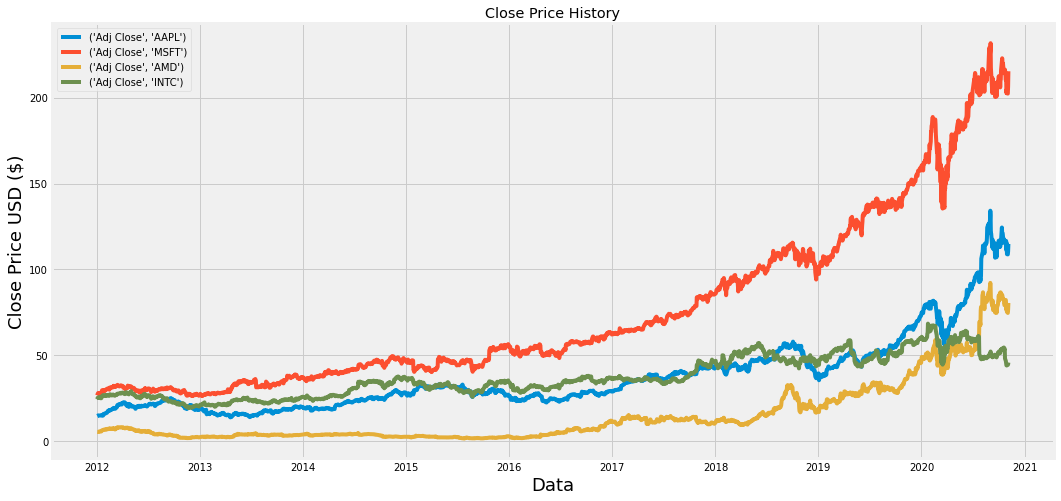

In [ ]:
#Visualize the closing price history for company data
plt.figure(figsize=(16, 8))
plt.title('Close Price History')
plt.plot(quotes.Close)
plt.legend(quotes)
plt.xlabel('Data', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show

In [ ]:
#Create new data frames from only the Close column
data = quotes.Close

#Convert the data frames to an array
dataset = data.values

#Convert the number of rows to train the model on
training_data_len = math.ceil(len(dataset) * .8)
training_data_len

1781

In [ ]:
data

Symbols,AAPL,MSFT,AMD,INTC
Date,,,,
2012-01-03,14.686786,26.770000,5.480000,24.540001
2012-01-04,14.765715,27.400000,5.460000,25.110001
2012-01-05,14.929643,27.680000,5.460000,25.400000
2012-01-06,15.085714,28.110001,5.430000,25.250000
2012-01-09,15.061786,27.740000,5.590000,25.469999
...,...,...,...,...
2020-10-29,115.320000,204.720001,78.019997,44.110001
2020-10-30,108.860001,202.470001,75.290001,44.279999
2020-11-02,108.769997,202.330002,74.699997,44.459999


In [ ]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset);
#scaled_data

In [ ]:
scaled_data.shape

(2226, 4)

In [ ]:
len(scaled_data)

2226

In [ ]:
#Create the training data set
#Create the scaled training data set
train_data = scaled_data[0:training_data_len, :]

In [ ]:
train_data

array([[0.0061488 , 0.00194856, 0.04262367, 0.1054775 ],
       [0.00680527, 0.00501753, 0.04240283, 0.1170841 ],
       [0.00816869, 0.00638153, 0.04240283, 0.12298919],
       ...,
       [0.20562244, 0.37300275, 0.19467756, 0.55345143],
       [0.2276007 , 0.38976032, 0.23708039, 0.57381389],
       [0.23007508, 0.38026112, 0.25165636, 0.56526162]])

In [ ]:
#Change the train data into a numpy array
train_data = np.array(train_data)
#Transpose the train data array
train_data = train_data.T
train_data[0]

array([0.0061488 , 0.00680527, 0.00816869, ..., 0.20562244, 0.2276007 ,
       0.23007508])

In [ ]:
#Creating the testing dataset
test_data = scaled_data[training_data_len - 60: , : ]
test_data.shape

(505, 4)

In [ ]:
#Create a numpy array of x train data 
#LSTM expects the input to be 3 dimensional in the form num of samples, num of timesteps, num of features
x_train = 0
x_train_flag = 0
for comp in range(train_data.shape[0]):
  x_train_layer = []
  for i in range(sample_size, train_data.shape[1]):
    x_train_layer.append(train_data[comp][i - 60: i]);
  x_train_layer = np.array(x_train_layer)
  if (x_train_flag == 0):
    x_train = x_train_layer
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_train_flag = 1
  else:
    x_train_layer = np.reshape(x_train_layer, (x_train_layer.shape[0], x_train_layer.shape[1], 1))
    x_train = np.concatenate((x_train, x_train_layer), axis=2)
  
x_train.shape

(1721, 60, 4)

In [ ]:
#Create a list of y training values
y_train = []
for i in range(60, train_data.shape[1]):
  y_train.append(train_data[target][i])
print(len(y_train))

1721


In [ ]:
#Convert y_train into a numpy array
y_train = np.array(y_train)

In [ ]:
#Building the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [ ]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

1721/1721 [==============================] - 11s 7ms/step - loss: 3.6184e-04


In [ ]:
#Create the dataset for testing 
test_data = scaled_data[training_data_len - 60: , :]
test_data = test_data.T
test_data.shape

(4, 505)

In [ ]:
#Create the data set for x_test
x_test = 0
x_test_flag = 0
print(test_data.shape[0])
for comp in range(test_data.shape[0]):
  x_test_layer = []
  for i in range(sample_size, test_data.shape[1]):
    x_test_layer.append(test_data[comp][i - 60: i]);
  x_test_layer = np.array(x_test_layer)
  if (x_test_flag == 0):
    x_test = x_test_layer
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    x_test_flag = 1
  else:
    x_test_layer = np.reshape(x_test_layer, (x_test_layer.shape[0], x_test_layer.shape[1], 1))
    x_test = np.concatenate((x_test, x_test_layer), axis=2)
  
x_test.shape

4


(445, 60, 4)

In [ ]:
#Create the data set for y_test
y_test = dataset[training_data_len:, :]
y_test

array([[ 41.61000061, 104.43000031,  24.40999985,  47.11999893],
       [ 41.63000107, 102.77999878,  24.51000023,  48.72999954],
       [ 42.8125    , 105.73999786,  24.12999916,  49.22000122],
       ...,
       [108.86000061, 202.47000122,  75.29000092,  44.27999878],
       [108.76999664, 202.33000183,  74.69999695,  44.45999908],
       [110.44000244, 206.42999268,  76.58000183,  44.84999847]])

In [ ]:
#Get the models predicted price values
predictions = model.predict(x_test)
#The scaler expects the array to be a multidimensional array
predictions = np.concatenate((predictions, predictions), axis=1)
predictions = np.concatenate((predictions, predictions), axis=1)
#Remove the scalling on the model
predictions = scaler.inverse_transform(predictions)
predictions = predictions.T[0].T
predictions = np.reshape(predictions, (predictions.shape[0], 1))
predictions.shape

(445, 1)

In [ ]:
#Get the root mean square error (RMSE)
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

48.939689285333934

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


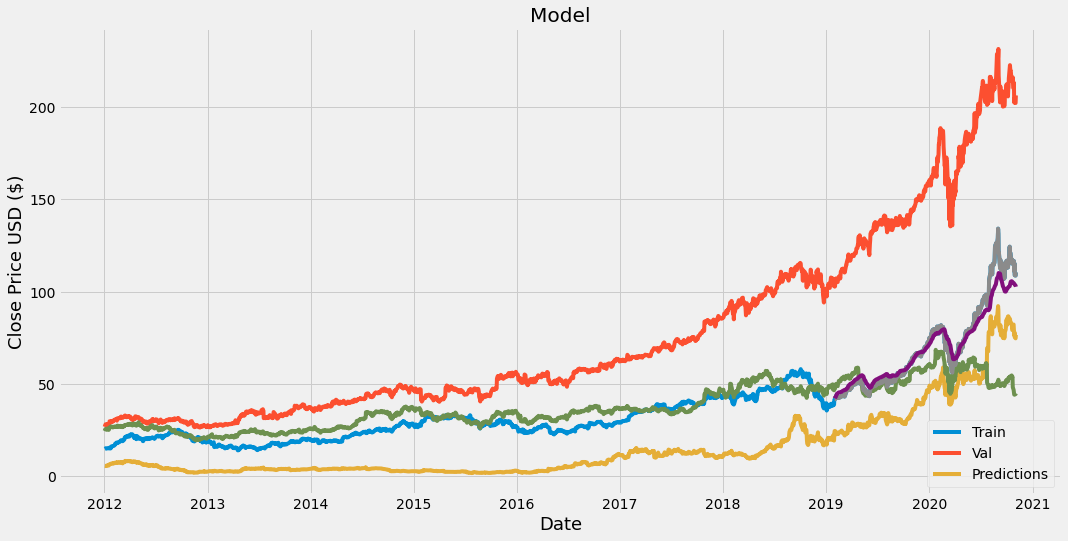

In [ ]:

#Plot the data
train = target_quotes[:training_data_len]
valid = target_quotes[training_data_len: ]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(quotes['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')